In [1]:
# Forcasting Cryptocurrency
# Data Analysis and Visualization
# Group 7

# TensorFlow model training routine

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Adapted/Refactored from Tensorflow Routines for Time Series Data
# https://www.tensorflow.org/tutorials/structured_data/time_series
'''Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo,
Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,
Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow,
Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,
Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,
Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,
Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,
Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,
Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,
Yuan Yu, and Xiaoqiang Zheng.'''

# TensorFlow: Large-scale machine learning on heterogeneous systems,
# 2015. Software available from tensorflow.org.


'Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo,\nZhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,\nJeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow,\nAndrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,\nLukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,\nRajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,\nBenoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,\nVincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,\nOriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,\nYuan Yu, and Xiaoqiang Zheng.'

In [2]:
# Initialize some graphic parameters
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = True

# read the input csv from the origin/source online
path = tf.keras.utils.get_file(
    origin='https://raw.githubusercontent.com/LaviJ/Cryptocurrency-Analysis/main/Data/Hourly/hourly_ADA.csv',
    fname='hourly_ADA.csv')
csv_path, _ = os.path.splitext(path)
df = pd.read_csv(csv_path+".csv")

5939200/5930880 [==============================] - 0s 0us/step


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Extract, Transform, and Load the data

# Read the csv into a dataframe and drop some columns/rows
df = pd.read_csv(csv_path+".csv")
df = df.drop('conversionType', axis=1)
df = df.drop('conversionSymbol', axis=1)
df = df.drop('volumeto', axis=1)
df = df.drop('volumefrom', axis=1)
df = df[(df != 0).all(1)]

# Move the timestamps into a list
date_time =[0]
date_time = df.pop('time')

In [4]:
df.head()

,high,low,open,close
0,1.297,1.284,1.288,1.290
1,1.296,1.281,1.285,1.288
2,1.297,1.279,1.296,1.285
3,1.315,1.295,1.296,1.296
4,1.314,1.292,1.310,1.296


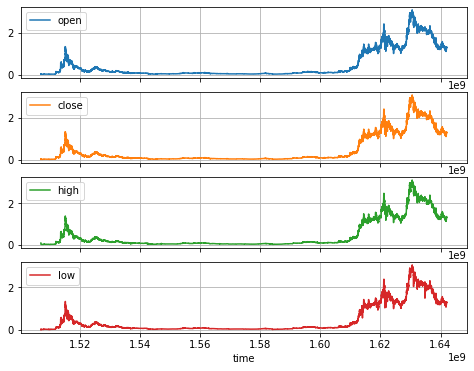

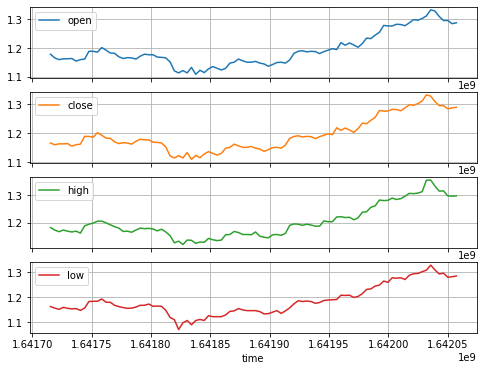

In [5]:
# Display the input data: since BTC genesis and last 96 hours
plot_cols = ['open', 'close', 'high', 'low']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:96]
plot_features.index = date_time[:96]
_ = plot_features.plot(subplots=True)

In [6]:
# Show the statistical description

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
high,37547.0,0.452377,0.675819,0.01795,0.050000,0.1011,0.40995,3.097
low,37547.0,0.443592,0.664275,0.01480,0.049215,0.0992,0.39455,3.052
open,37547.0,0.448090,0.670270,0.01782,0.049545,0.1001,0.40130,3.093
close,37547.0,0.448126,0.670285,0.01782,0.049555,0.1001,0.40225,3.093


In [7]:
# Define sinusoid wave periods

timestamp_s = date_time 

# define a day, although we won't use the daily curve for crypto
day = 24*60*60

# the weekend and business week happen on a weekly basis
week = 7*day

# paychecks are signed every two weeks
biweek = 2*week

# The holiday season is annual
year = (365.2425)*day

# Quarterly earnings reports happen quarterly
quarter = (365.2425/4)*day

# Load the waves into the dataframe
df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['Biweek sin'] = np.sin(timestamp_s * (2 * np.pi / biweek))
df['Biweek cos'] = np.cos(timestamp_s * (2 * np.pi / biweek))
df['Quarter sin'] = np.sin(timestamp_s * (2 * np.pi / quarter))
df['Quarter cos'] = np.cos(timestamp_s * (2 * np.pi / quarter))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of week signal')

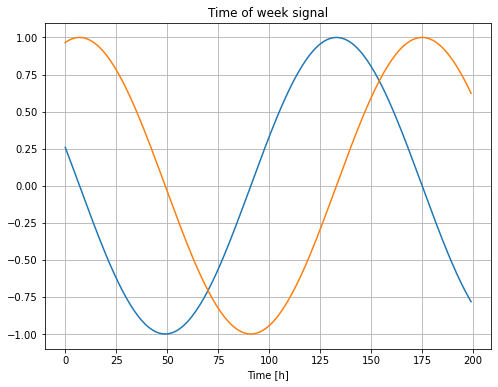

In [8]:
# Display the weekly signal

plt.plot(np.array(df['Week sin'])[:200])
plt.plot(np.array(df['Week cos'])[:200])
plt.xlabel('Time [h]')
plt.title('Time of week signal')

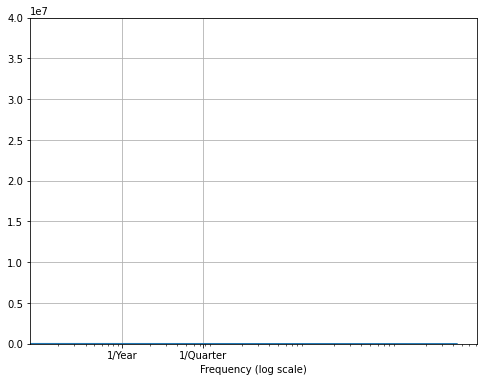

In [9]:
# Use FFT to display frequency domain

fft = tf.signal.rfft(df['close'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['close'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524/(12*4)], labels=['1/Year', '1/Quarter'])
_ = plt.xlabel('Frequency (log scale)')

In [10]:
df

,high,low,open,close,Week sin,Week cos,Biweek sin,Biweek cos,Quarter sin,Quarter cos,Year sin,Year cos
0,1.29700,1.28400,1.28800,1.29000,0.258819,0.965926,-0.130526,-0.991445,0.766028,0.642807,0.216433,0.976297
1,1.29600,1.28100,1.28500,1.28800,0.222521,0.974928,-0.111964,-0.993712,0.764182,0.645000,0.215734,0.976452
2,1.29700,1.27900,1.29600,1.28500,0.185912,0.982566,-0.093364,-0.995632,0.762330,0.647189,0.215034,0.976607
3,1.31500,1.29500,1.29600,1.29600,0.149042,0.988831,-0.074730,-0.997204,0.760471,0.649372,0.214334,0.976761
4,1.31400,1.29200,1.31000,1.29600,0.111964,0.993712,-0.056070,-0.998427,0.758606,0.651550,0.213633,0.976914
...,...,...,...,...,...,...,...,...,...,...,...,...
37543,0.03050,0.02416,0.02519,0.02961,-0.433884,-0.900969,-0.974928,0.222521,0.046130,0.998935,-0.999933,0.011536
37544,0.02743,0.01805,0.01826,0.02519,-0.399892,-0.916562,-0.978918,0.204252,0.043266,0.999064,-0.999941,0.010820
37545,0.02464,0.01707,0.02220,0.01826,-0.365341,-0.930874,-0.982566,0.185912,0.040401,0.999184,-0.999949,0.010103
37546,0.03131,0.02181,0.02999,0.02220,-0.330279,-0.943883,-0.985871,0.167506,0.037536,0.999295,-0.999956,0.009386


In [11]:
# Use a (70%, 20%, 10%) split for the training, validation, and test sets. 
# Note the data is not being randomly shuffled before splitting.

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [12]:
# Normalize training datasets

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

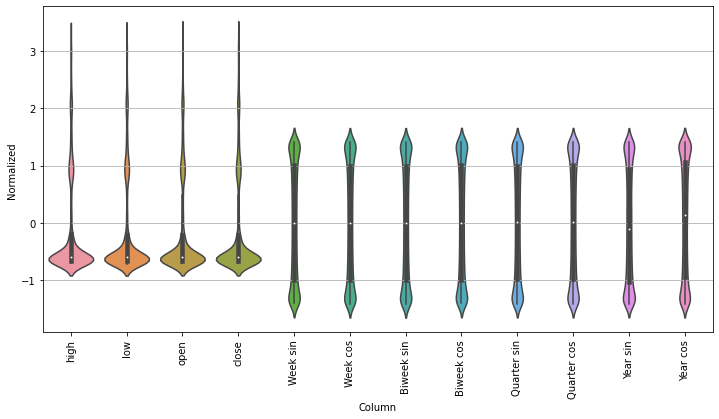

In [13]:
# Show distribution

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [14]:
# Define TensorFlow windows

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
# Generate a window

w1 = WindowGenerator(input_width=96, label_width=1, shift=96,
                     label_columns=['close'])
w1

Total window size: 192
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [191]
Label column name(s): ['close']

In [16]:
# Generate another window

w2 = WindowGenerator(input_width=60, label_width=1, shift=1,
                     label_columns=['close'])
w2

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60]
Label column name(s): ['close']

In [17]:
# Create slices

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 61, 12)
Inputs shape: (3, 60, 12)
Labels shape: (3, 1, 1)


In [18]:
w1.example = example_inputs, example_labels

In [19]:
# Define a method to generate mean error plots

def plot(self, model=None, plot_col='close', max_subplots=6):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [20]:
#  This make_dataset method will take a time series DataFrame and convert
#  it to a tf.data.Dataset of (input_window, label_window) pairs using the 
#  tf.keras.utils.timeseries_dataset_from_array function

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

# The WindowGenerator object holds training, validation, and test data.
# accessing them as tf.data.Datasets using the make_dataset method as
# defined earlier
WindowGenerator.make_dataset = make_dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
# Each element is an (inputs, label) pair. 
# Display the structure, data types, and shapes of the dataset elements.
w1.train.element_spec

(TensorSpec(shape=(None, 96, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [22]:
# Iterate over the training set
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 60, 12)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

Predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

In [23]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [24]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 12)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

The baseline returns the single input as the prediction, predicting "No change". 

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [25]:
# Instantiate and evaluate the single-step baseline model

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices['close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

235/235 [==============================] - 0s 1ms/step - loss: 1.0728e-05 - mean_absolute_error: 0.0020


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [26]:
# Create a wider WindowGenerator that generates windows 60 hours of consecutive
# inputs and labels at a time.
wide_window = WindowGenerator(
    input_width=60, label_width=60, shift=1,
    label_columns=['close'])

wide_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
Label column name(s): ['close']

Shifted-window baseline: one prediction 1 hour into the future every hour.

![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [27]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 60, 12)
Output shape: (32, 60, 1)


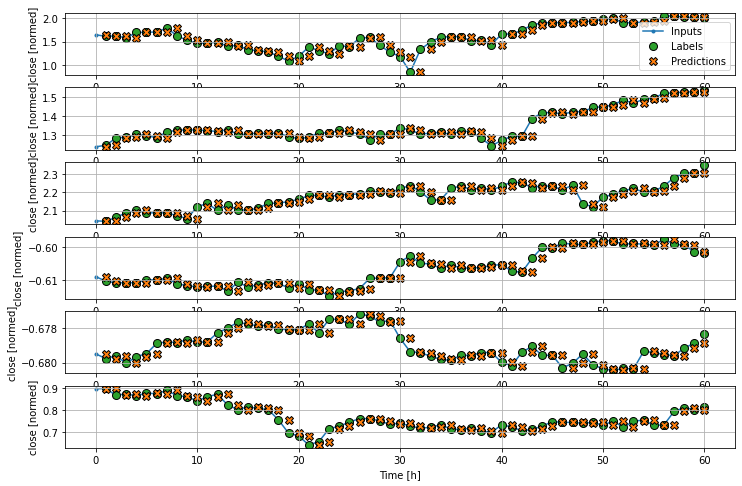

In [28]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

Linear transformation between the input and output. 

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

In [29]:
# A tf.keras.layers.Dense layer with no activation set is a linear model.
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [30]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 12)
Output shape: (32, 1, 1)


In [31]:
# Define the training procedure

MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [32]:
# Train the linear model

history = compile_and_fit(linear, single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=1)

Epoch 1/100
822/822 [==============================] - 1s 791us/step - loss: 1.0988 - mean_absolute_error: 0.6887 - val_loss: 0.0385 - val_mean_absolute_error: 0.1656
Epoch 2/100
822/822 [==============================] - 1s 706us/step - loss: 0.0082 - mean_absolute_error: 0.0637 - val_loss: 2.9404e-04 - val_mean_absolute_error: 0.0149
Epoch 3/100
822/822 [==============================] - 1s 739us/step - loss: 2.7326e-04 - mean_absolute_error: 0.0087 - val_loss: 9.2929e-06 - val_mean_absolute_error: 0.0020
Epoch 4/100
822/822 [==============================] - 1s 703us/step - loss: 2.3555e-04 - mean_absolute_error: 0.0062 - val_loss: 9.2376e-06 - val_mean_absolute_error: 0.0019
Epoch 5/100
822/822 [==============================] - 1s 705us/step - loss: 2.3566e-04 - mean_absolute_error: 0.0063 - val_loss: 9.3318e-06 - val_mean_absolute_error: 0.0020
Epoch 6/100
822/822 [==============================] - 1s 669us/step - loss: 2.3561e-04 - mean_absolute_error: 0.0064 - val_loss: 9.3856e

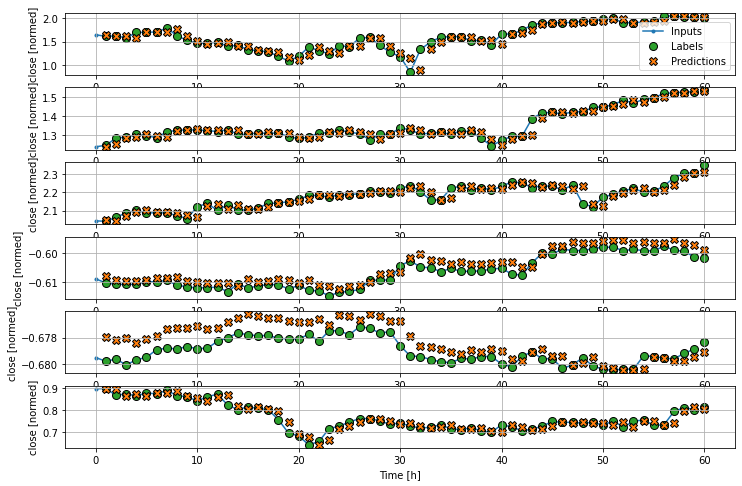

In [33]:
wide_window.plot(linear)

Like the `baseline` model, the linear model can be called on batches of wide windows.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [34]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 60, 12)
Output shape: (32, 60, 1)


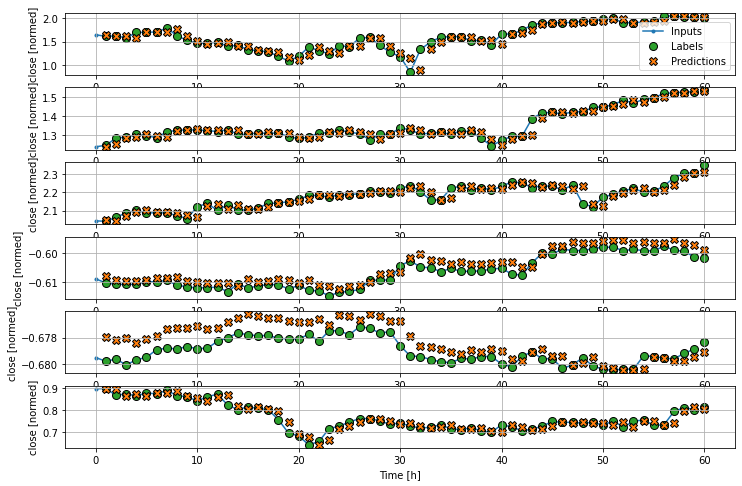

In [35]:
wide_window.plot(linear)

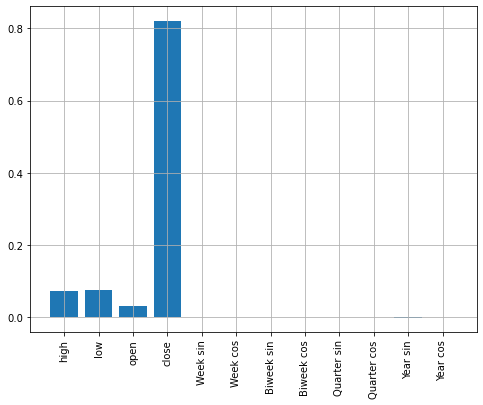

In [36]:
# Show the weight of each component to the linear model

plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [37]:
# Stack a few dense analysis layers in between the input and output and train

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
822/822 [==============================] - 1s 978us/step - loss: 0.0148 - mean_absolute_error: 0.0470 - val_loss: 0.0012 - val_mean_absolute_error: 0.0253
Epoch 2/100
822/822 [==============================] - 1s 840us/step - loss: 4.4835e-04 - mean_absolute_error: 0.0159 - val_loss: 8.1400e-04 - val_mean_absolute_error: 0.0201
Epoch 3/100
822/822 [==============================] - 1s 836us/step - loss: 2.9970e-04 - mean_absolute_error: 0.0128 - val_loss: 6.1527e-04 - val_mean_absolute_error: 0.0176
Epoch 4/100
822/822 [==============================] - 1s 842us/step - loss: 2.5513e-04 - mean_absolute_error: 0.0118 - val_loss: 4.8641e-04 - val_mean_absolute_error: 0.0151
Epoch 5/100
822/822 [==============================] - 1s 777us/step - loss: 2.3997e-04 - mean_absolute_error: 0.0114 - val_loss: 4.4996e-04 - val_mean_absolute_error: 0.0156
Epoch 6/100
822/822 [==============================] - 1s 850us/step - loss: 2.7536e-04 - mean_absolute_error: 0.0121 - val_loss: 3.8

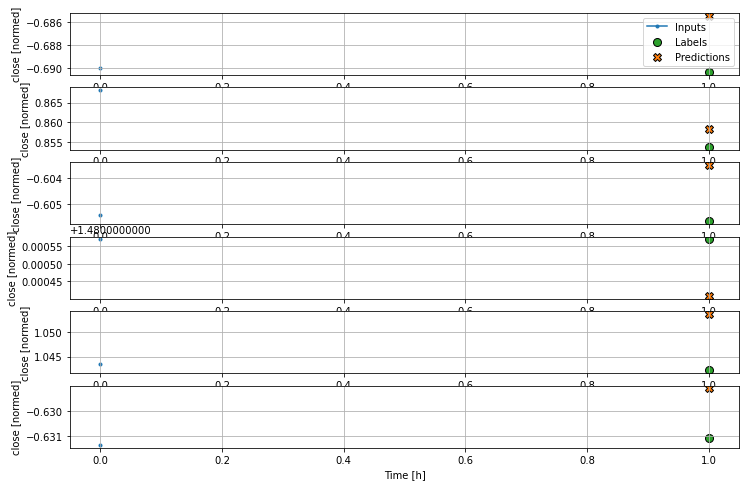

In [38]:
single_step_window.plot(dense)

### Multi-step dense

Access to multiple time steps when making predictions.

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


In [39]:
# Create a WindowGenerator that will produce batches of three-hour inputs and one-hour labels:
# Note that the Window's shift parameter is relative to the end of the two windows.

CONV_WIDTH = 60
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['close'])

conv_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60]
Label column name(s): ['close']

Text(0.5, 1.0, 'Given 60 hours of inputs, predict 1 hour into the future.')

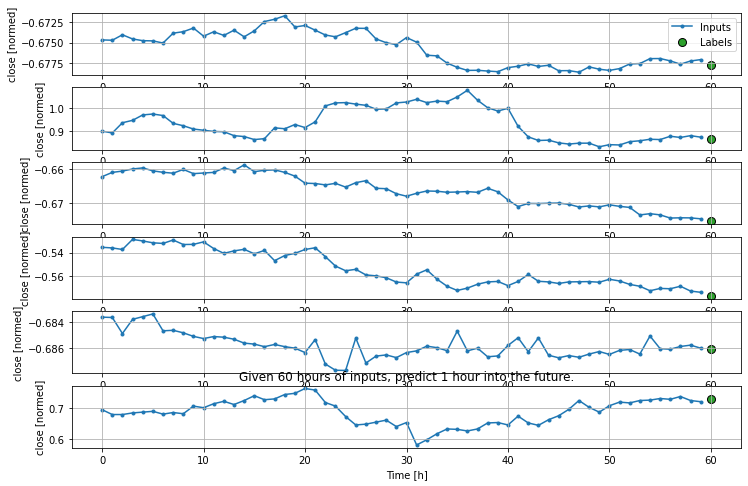

In [40]:
conv_window.plot()
plt.title("Given 60 hours of inputs, predict 1 hour into the future.")

In [41]:
#  Define a dense model on a multiple-input-step window by adding a 
#  tf.keras.layers.Flatten as the first layer of the model:

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [42]:
# Display the shapes
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 60, 12)
Output shape: (32, 1, 1)


In [43]:
# Run the training

history = compile_and_fit(multi_step_dense, conv_window)
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/100
820/820 [==============================] - 1s 1ms/step - loss: 0.0130 - mean_absolute_error: 0.0651 - val_loss: 0.0020 - val_mean_absolute_error: 0.0345
Epoch 2/100
820/820 [==============================] - 1s 961us/step - loss: 0.0022 - mean_absolute_error: 0.0300 - val_loss: 6.2977e-04 - val_mean_absolute_error: 0.0185
Epoch 3/100
820/820 [==============================] - 1s 846us/step - loss: 0.0018 - mean_absolute_error: 0.0236 - val_loss: 3.6870e-04 - val_mean_absolute_error: 0.0135
Epoch 4/100
820/820 [==============================] - 1s 875us/step - loss: 0.0012 - mean_absolute_error: 0.0202 - val_loss: 6.0596e-04 - val_mean_absolute_error: 0.0181
Epoch 5/100
820/820 [==============================] - 1s 899us/step - loss: 0.0013 - mean_absolute_error: 0.0210 - val_loss: 3.1449e-04 - val_mean_absolute_error: 0.0109
Epoch 6/100
820/820 [==============================] - 1s 868us/step - loss: 0.0011 - mean_absolute_error: 0.0202 - val_loss: 4.2398e-04 - val_mean_abs

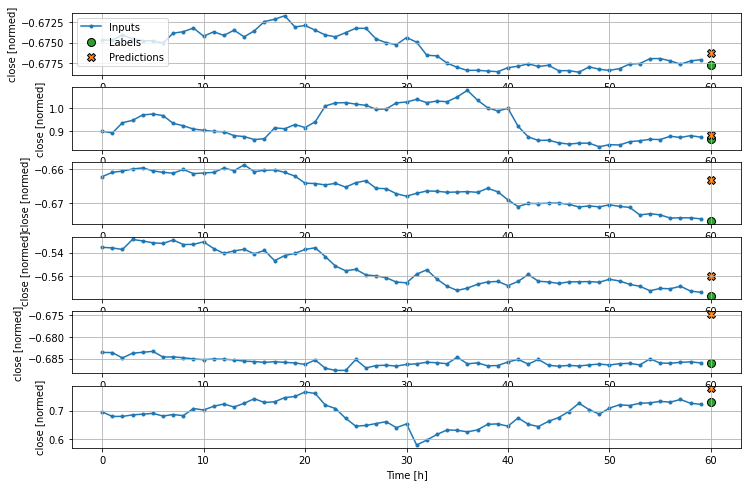

In [44]:
conv_window.plot(multi_step_dense)

### Convolution neural network
 Multiple time steps as input to each prediction.

In [45]:
# Define the CNN

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [46]:
# Run it on an example batch to check that the model produces outputs
# with the expected shape:

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 60, 12)
Output shape: (32, 1, 1)


In [47]:
#Train and evaluate it on the conv_window  

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

233/233 [==============================] - 0s 608us/step - loss: 3.4188e-04 - mean_absolute_error: 0.0154


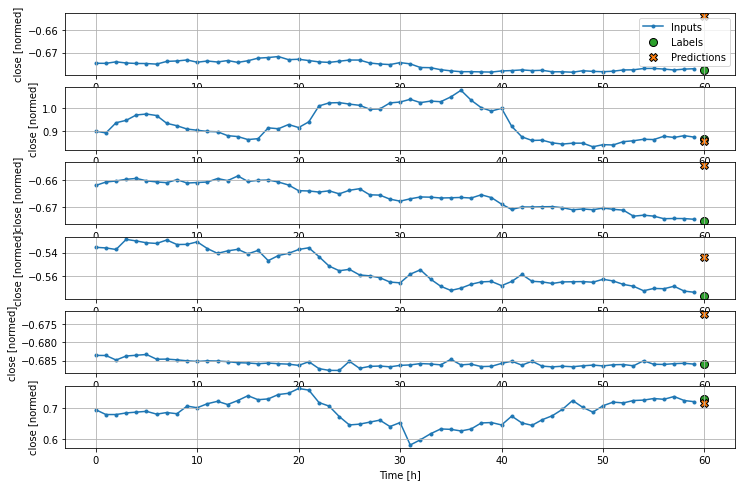

In [48]:
conv_window.plot(conv_model)

The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

In [49]:
# If you run it on wider input, it produces wider output
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 60, 12)
Labels shape: (32, 60, 1)
Output shape: (32, 1, 1)


In [50]:
# Declare a wide convolution window

LABEL_WIDTH = 60
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['close'])

wide_conv_window

Total window size: 120
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]
Label indices: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
Label column name(s): ['close']

In [51]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 119, 12)
Labels shape: (32, 60, 1)
Output shape: (32, 60, 1)


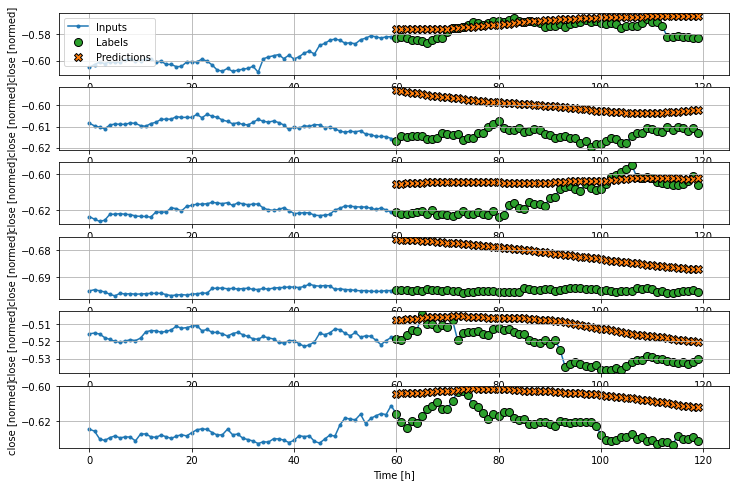

In [52]:
# plot the model's predictions on a wider window.

wide_conv_window.plot(conv_model)

### Recurrent neural network

RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step. We will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [53]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [54]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 60, 12)
Output shape: (32, 60, 1)


In [55]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

233/233 [==============================] - 1s 3ms/step - loss: 1.2015e-05 - mean_absolute_error: 0.0026


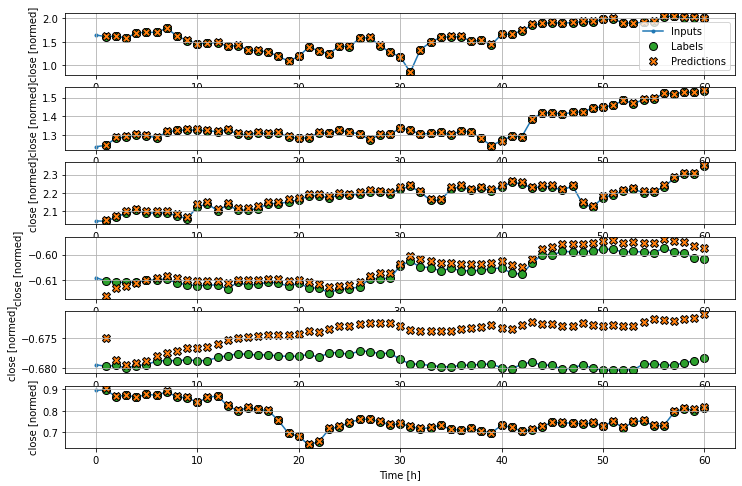

In [56]:
wide_window.plot(lstm_model)

### Performance

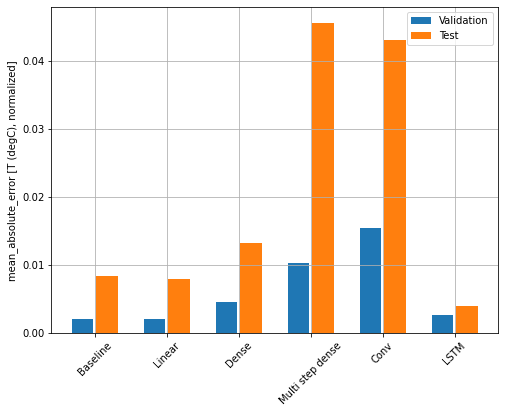

In [57]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [58]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0084
Linear      : 0.0079
Dense       : 0.0132
Multi step dense: 0.0456
Conv        : 0.0430
LSTM        : 0.0040


### Multi-output models

predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features.

In [59]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 12)
Labels shape (batch, time, features): (32, 24, 12)


In [60]:
# Define and run a baseline repeating all features.

baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

234/234 [==============================] - 0s 489us/step - loss: 2.9608e-04 - mean_absolute_error: 0.0096


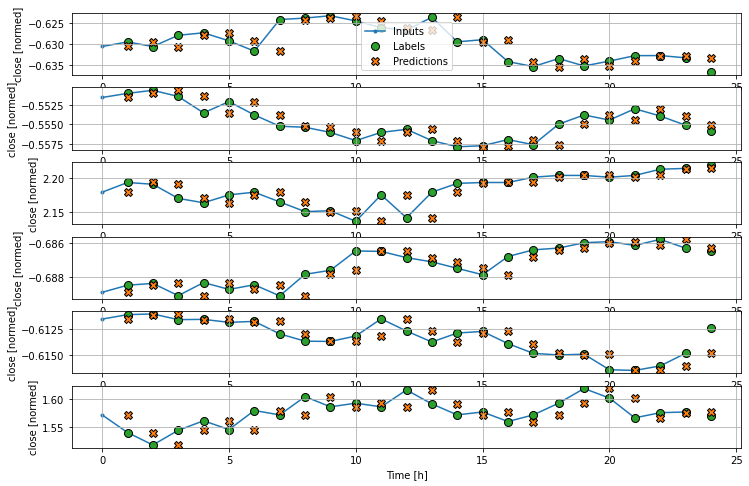

In [61]:
wide_window.plot(baseline)

#### Dense

In [62]:
# Add some dense layers in between the input and output.

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [63]:
# Train the multi dense model.

history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/100
822/822 [==============================] - 1s 935us/step - loss: 0.0661 - mean_absolute_error: 0.1300 - val_loss: 0.0034 - val_mean_absolute_error: 0.0458
Epoch 2/100
822/822 [==============================] - 1s 853us/step - loss: 0.0024 - mean_absolute_error: 0.0380 - val_loss: 0.0016 - val_mean_absolute_error: 0.0317
Epoch 3/100
822/822 [==============================] - 1s 812us/step - loss: 0.0014 - mean_absolute_error: 0.0285 - val_loss: 0.0011 - val_mean_absolute_error: 0.0255
Epoch 4/100
822/822 [==============================] - 1s 826us/step - loss: 8.8210e-04 - mean_absolute_error: 0.0228 - val_loss: 7.4477e-04 - val_mean_absolute_error: 0.0213
Epoch 5/100
822/822 [==============================] - 1s 842us/step - loss: 6.4504e-04 - mean_absolute_error: 0.0194 - val_loss: 5.4222e-04 - val_mean_absolute_error: 0.0183
Epoch 6/100
822/822 [==============================] - 1s 852us/step - loss: 4.7517e-04 - mean_absolute_error: 0.0164 - val_loss: 3.5785e-04 - val_me

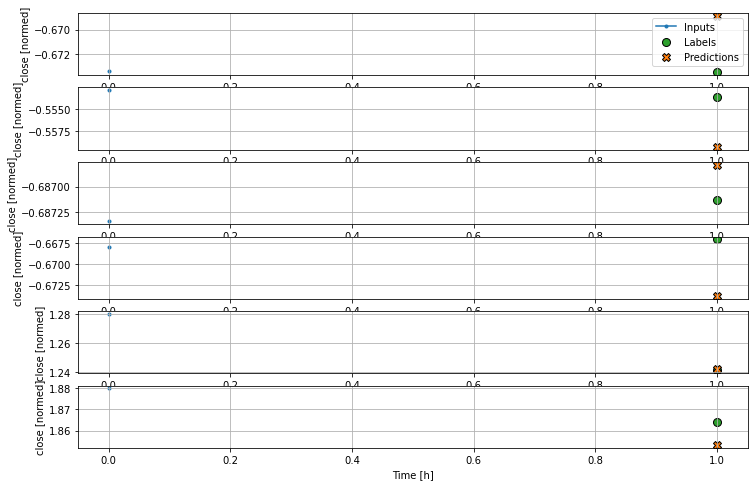

In [64]:
single_step_window.plot(dense)

#### RNN: LSTM (Long Short-Term Memory)


In [65]:
%%time

# Declare and train the wide LSTM model

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

Epoch 1/100
821/821 [==============================] - 5s 5ms/step - loss: 0.1162 - mean_absolute_error: 0.2040 - val_loss: 0.0161 - val_mean_absolute_error: 0.0681
Epoch 2/100
821/821 [==============================] - 4s 5ms/step - loss: 0.0101 - mean_absolute_error: 0.0517 - val_loss: 0.0052 - val_mean_absolute_error: 0.0358
Epoch 3/100
821/821 [==============================] - 4s 5ms/step - loss: 0.0036 - mean_absolute_error: 0.0309 - val_loss: 0.0019 - val_mean_absolute_error: 0.0233
Epoch 4/100
821/821 [==============================] - 4s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0210 - val_loss: 7.3702e-04 - val_mean_absolute_error: 0.0161
Epoch 5/100
821/821 [==============================] - 4s 5ms/step - loss: 6.5822e-04 - mean_absolute_error: 0.0152 - val_loss: 3.6177e-04 - val_mean_absolute_error: 0.0120
Epoch 6/100
821/821 [==============================] - 4s 5ms/step - loss: 4.0868e-04 - mean_absolute_error: 0.0121 - val_loss: 2.3246e-04 - val_mean_absolute_erro

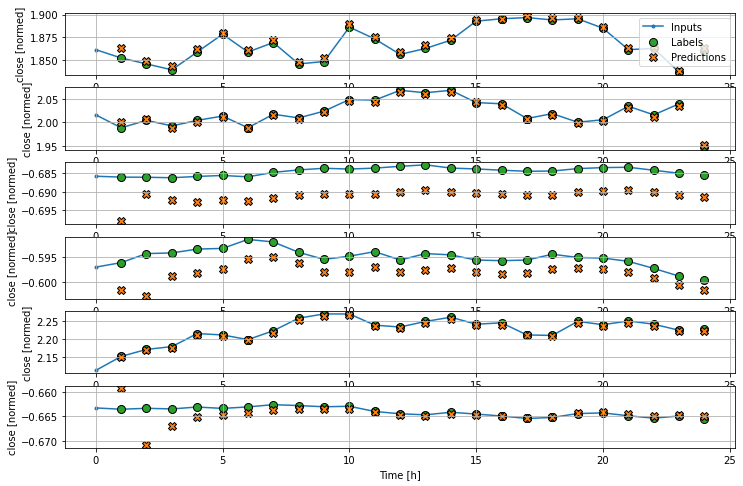

In [66]:
wide_window.plot(lstm_model)

 
# Residual Networks,  ResNets:
## Architectures where each layer adds to the model's accumulating result.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)


In [67]:
# Define the residual connection properties

class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [68]:
%%time

# Train a Res-Net

residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

Epoch 1/100
821/821 [==============================] - 5s 5ms/step - loss: 1.0379e-04 - mean_absolute_error: 0.0031 - val_loss: 4.9792e-06 - val_mean_absolute_error: 0.0012
Epoch 2/100
821/821 [==============================] - 4s 5ms/step - loss: 9.5114e-05 - mean_absolute_error: 0.0026 - val_loss: 5.1803e-06 - val_mean_absolute_error: 0.0012
Epoch 3/100
821/821 [==============================] - 4s 5ms/step - loss: 7.6211e-05 - mean_absolute_error: 0.0024 - val_loss: 4.9814e-06 - val_mean_absolute_error: 0.0012
Epoch 4/100
821/821 [==============================] - 4s 5ms/step - loss: 6.0363e-05 - mean_absolute_error: 0.0021 - val_loss: 4.0696e-06 - val_mean_absolute_error: 0.0010
Epoch 5/100
821/821 [==============================] - 4s 5ms/step - loss: 5.6590e-05 - mean_absolute_error: 0.0019 - val_loss: 3.7222e-06 - val_mean_absolute_error: 9.4348e-04
Epoch 6/100
821/821 [==============================] - 4s 5ms/step - loss: 5.5139e-05 - mean_absolute_error: 0.0019 - val_loss: 3.5

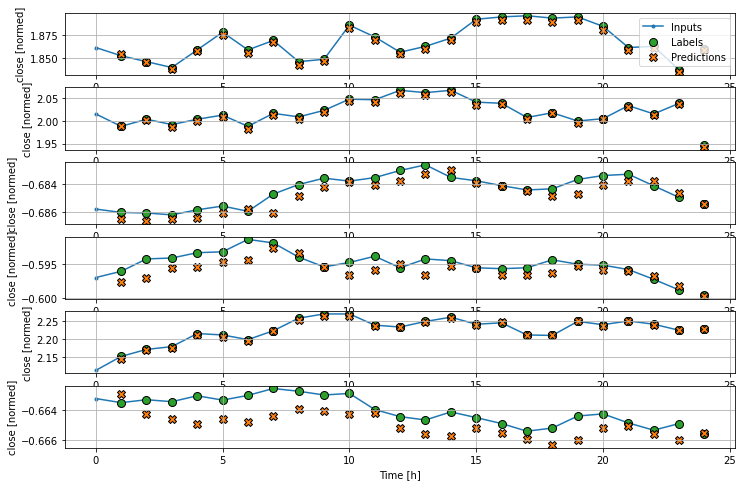

In [69]:
wide_window.plot(residual_lstm)

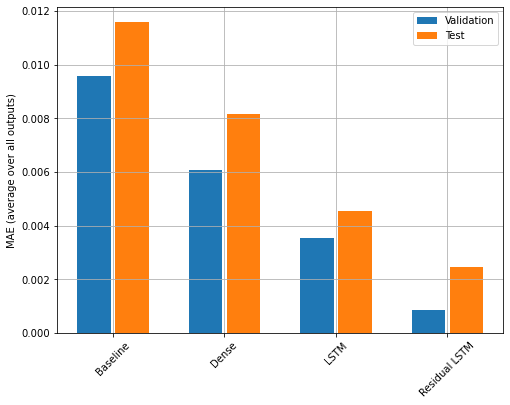

In [70]:
# Display training performance metrics

x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [71]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.0116
Dense          : 0.0081
LSTM           : 0.0046
Residual LSTM  : 0.0025


Total window size: 192
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): None

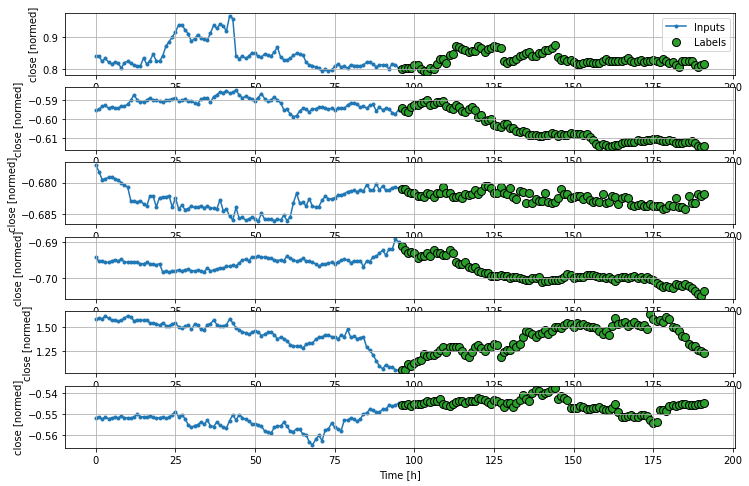

In [72]:
# Create a model to learn to predict 96 hours into the future, given 96 hours
# of the past.

OUT_STEPS = 96
multi_window = WindowGenerator(input_width=96,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

The baseline model uses the last input for each output.

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

229/229 [==============================] - 0s 518us/step - loss: 0.5360 - mean_absolute_error: 0.3630


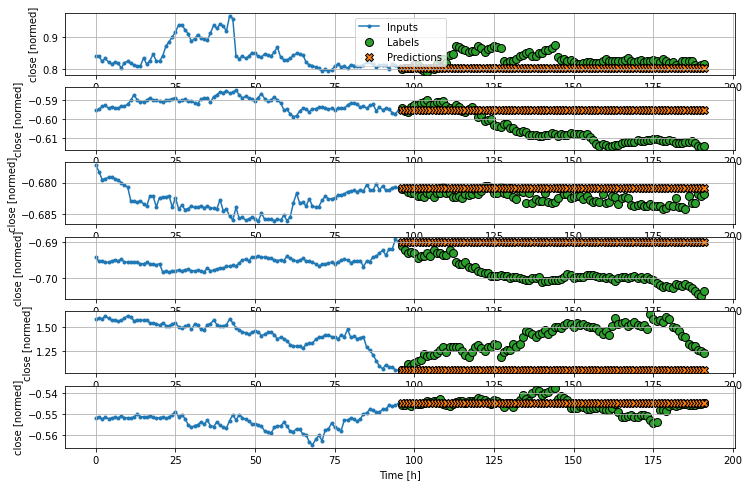

In [73]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 96 hours into the future, given 96 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous 96](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

229/229 [==============================] - 0s 535us/step - loss: 1.0547 - mean_absolute_error: 0.5849


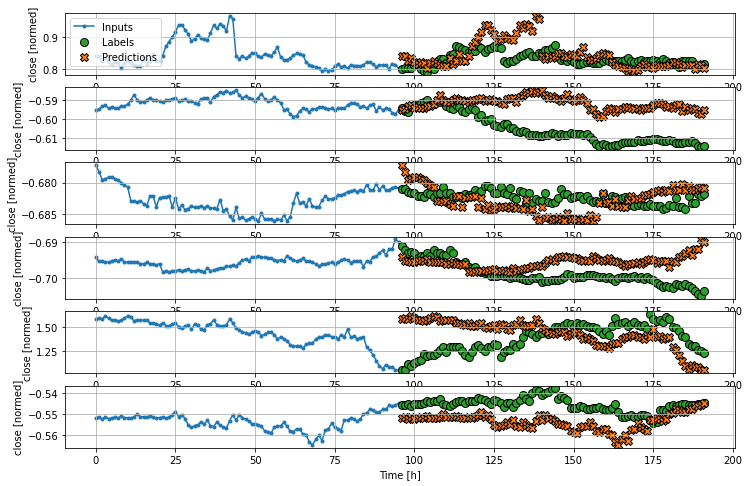

In [74]:
# Calculate the Repeat model

class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered.

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

229/229 [==============================] - 0s 585us/step - loss: 1.7261e-04 - mean_absolute_error: 0.0051


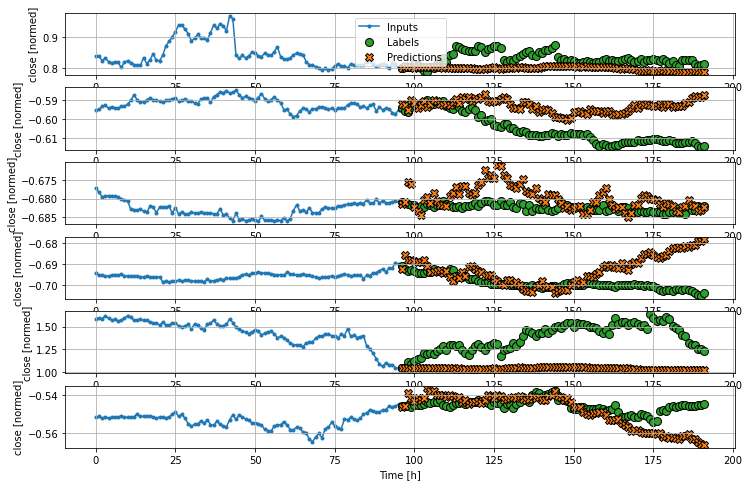

In [75]:
# Calculate the Linear model

multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

229/229 [==============================] - 0s 1ms/step - loss: 5.6396e-04 - mean_absolute_error: 0.0151


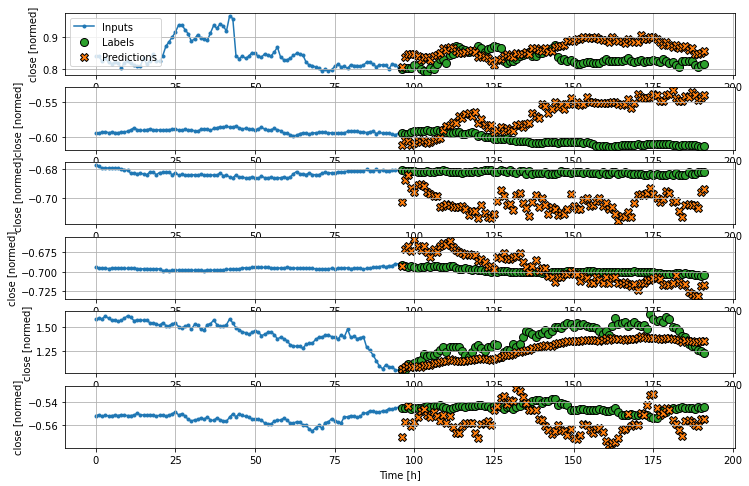

In [76]:
# Calculate the dense-layer model

multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN: The Convolutional Neural Network

A convolutional model makes predictions based on a fixed-width history.

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

229/229 [==============================] - 0s 1ms/step - loss: 7.8903e-04 - mean_absolute_error: 0.0198


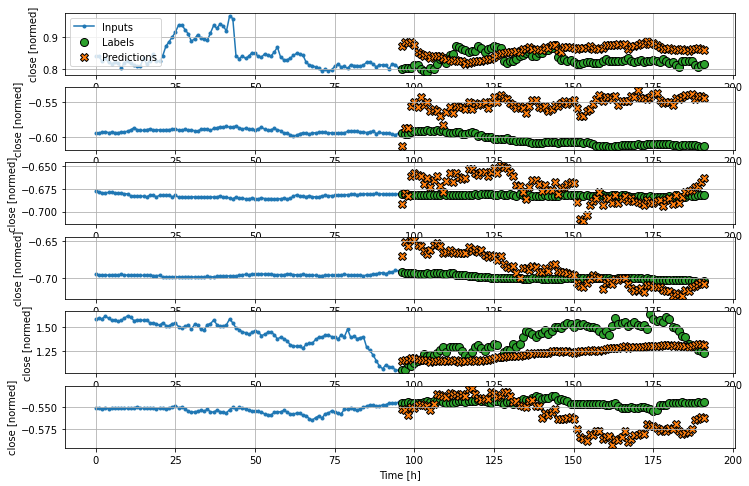

In [77]:
# Train the convolutional model

CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN: Recurrent Neural Networks

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 96 hours, before making a single prediction for the next 96 hours.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


229/229 [==============================] - 1s 5ms/step - loss: 3.6509e-04 - mean_absolute_error: 0.0119


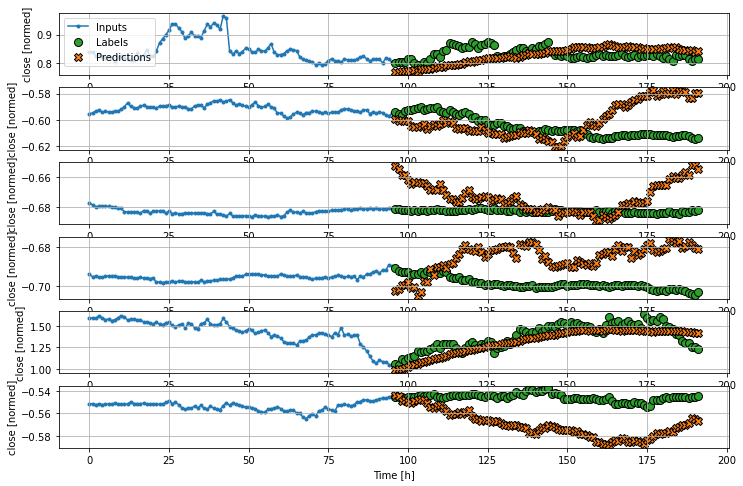

In [78]:
# Calculate the Recurrent model

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
""
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Autoregressive model

Output can be fed back into itself at each step and predictions can be made conditioned on the previous one.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

In [88]:
# Define the Autoregressive RNN LSTM model
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [89]:
 # A warmup method to initialize internal state based on the inputs.
 
 def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [91]:
# Display the tesor shape
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 12])

In [92]:
# Define the feedback method

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [93]:
# Print the output shape

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 96, 12)


229/229 [==============================] - 2s 8ms/step - loss: 0.3472 - mean_absolute_error: 0.4101


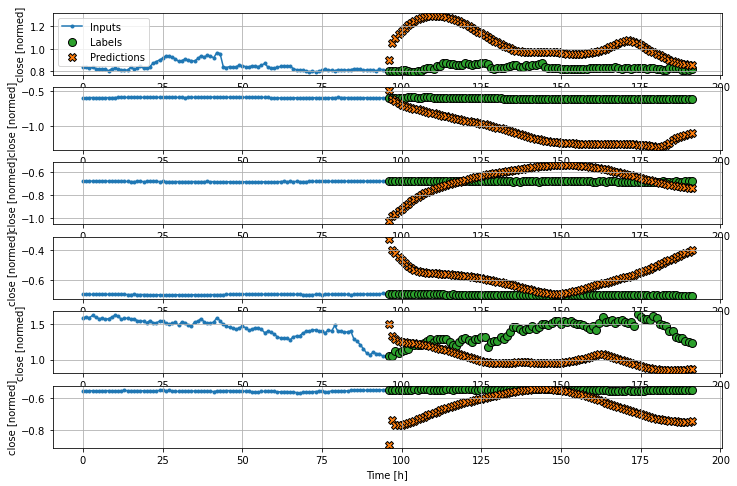

In [94]:
# Train the Autoregressive RNN feedback model 
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

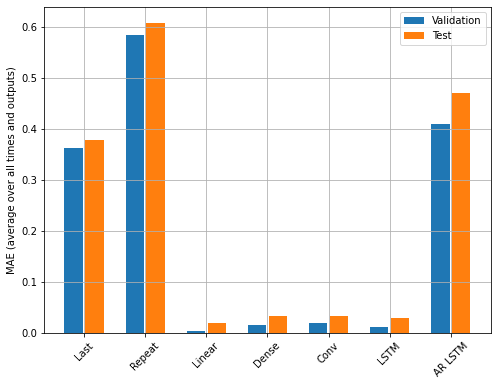

In [95]:
# Show the performance graphs

x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [96]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.3785
Repeat  : 0.6091
Linear  : 0.0204
Dense   : 0.0333
Conv    : 0.0341
LSTM    : 0.0305
AR LSTM : 0.4709


In [97]:
# Save the feedback_model

feedback_model.save("ADAfeedback_model")

INFO:tensorflow:Assets written to: ADAfeedback_model\assets
